In [1]:
import warnings

warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import struct
import random
import os
import gzip
import numpy as np
import time
import matplotlib.pyplot as plt
import torchvision
import pandas as pd
import seaborn as sns
import torchvision.transforms.functional as F
from urllib.request import urlopen
from torch.optim import Adam, SGD
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim import lr_scheduler
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision import models
from tqdm.notebook import tqdm
from tempfile import TemporaryDirectory

### References:

- [Backprop explanation](https://datascience.stackexchange.com/questions/36707/backpropagation-simplest-explanation),
- [Role of derivative](https://datascience.stackexchange.com/questions/30676/role-derivative-of-sigmoid-function-in-neural-networks/30679#30679),
- [Backrop once again](https://datascience.stackexchange.com/questions/28719/a-good-reference-for-the-back-propagation-algorithm/28738#28738),
- [AGH Backprop steps](https://home.agh.edu.pl/~vlsi/AI/backp_t_en/backprop.html),
- [Gradient descent and derivatives](https://datascience.stackexchange.com/questions/28691/gradient-descent-and-partial-derivatives/28699#28699),
- [Backprop in CNN](https://datascience.stackexchange.com/questions/27506/back-propagation-in-cnn/27751#27751).

In [2]:
%matplotlib inline

In [3]:
torch.manual_seed(1337)
np.random.seed(1337)
random.seed(1337)
torch.set_printoptions(sci_mode=False)
np.set_printoptions(suppress=True)

In [4]:
TRAIN_DATA_URL = r"http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz"
TRAIN_DATA_LABELS_URL = r"http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"
TEST_DATA_URL = r"http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz"
TEST_DATA_LABELS_URL = r"http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"

In [5]:
def load_dataset(url):
    fname = url.split("/")[-1]
    with urlopen(url) as fsrc:
        with gzip.open(fsrc, "rb") as f:
            magic, size = struct.unpack(">II", f.read(8))
            if "images" in fname:
                nrows, ncols = struct.unpack(">II", f.read(8))
            data = np.frombuffer(f.read(), dtype=np.dtype(np.uint8).newbyteorder(">"))
            data = data.reshape((size, nrows, ncols) if "images" in fname else (size,))
        return data

In [6]:
train_images_dataset = load_dataset(TRAIN_DATA_URL)
train_labels_dataset = load_dataset(TRAIN_DATA_LABELS_URL)

test_images_dataset = load_dataset(TEST_DATA_URL)
test_labels_dataset = load_dataset(TEST_DATA_LABELS_URL)

In [7]:
X_train = torch.tensor(train_images_dataset, dtype=torch.float32)
y_train = torch.tensor(train_labels_dataset, dtype=torch.long).reshape(-1, 1)

X_test = torch.tensor(test_images_dataset, dtype=torch.float32)
y_test = torch.tensor(test_labels_dataset, dtype=torch.long).reshape(-1, 1)

X_train_norm = X_train / 255
X_test_norm = X_test / 255

indexes = torch.randperm(X_train_norm.shape[0])
X_train = X_train_norm[indexes]
y_train = y_train[indexes]

X_test = X_test_norm

In [8]:
def show_grid(n_images, dataset):
    if n_images % 2 != 0 and n_images < 4:
        raise ValueError("Wrong value!")
    G = n_images
    fig = plt.figure(figsize=(10.0, 10.0))
    grid = ImageGrid(
        fig,
        111,
        nrows_ncols=(G // 4, G // 4),
        axes_pad=0.1,
    )
    img_arr = dataset[:G, :, :]
    for ax, im in zip(grid, img_arr):
        ax.imshow(im, cmap="gray")
        ax.axis("off")

    plt.show();

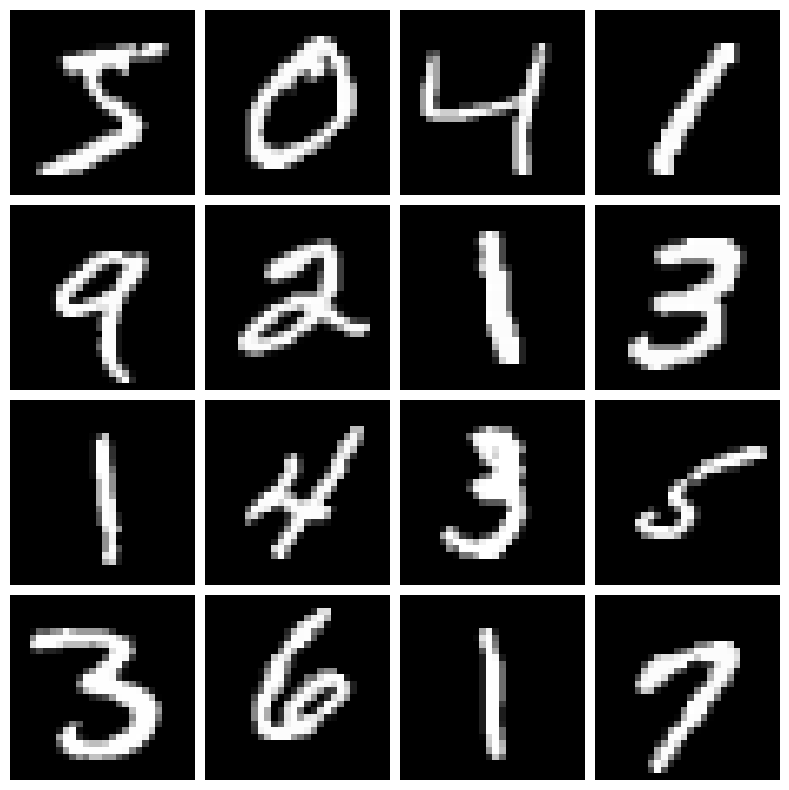

In [9]:
show_grid(n_images=16, dataset=train_images_dataset)

### PyTorch CNN pretrained AlexNet

[PyTorch Transfer Learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [10]:
model_ft = models.alexnet(pretrained=True, progress=True)
num_classes = 10

# Transfer Learning final layer
model_ft.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=9216, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=num_classes, bias=True),
)

for name, child in model_ft.named_children():
    if name in ['features', 'avgpool']:
        for param in child.parameters():
            param.requires_grad = False
    
print(f'Model total parameters: {sum(p.numel() for p in model_ft.parameters())}')
print(f'Model trainable parameters: {sum(p.numel() for p in model_ft.parameters() if p.requires_grad)}')

Model total parameters: 40263498
Model trainable parameters: 37793802


In [11]:
train_data = TensorDataset(X_train, y_train.view(-1))

train_size = int(0.8 * len(train_data))  # 20% for validation dataset
val_size = len(train_data) - train_size

train_dataset, val_dataset = random_split(train_data, [train_size, val_size])
test_dataset = TensorDataset(X_test, y_test.view(-1))
dataset_sizes = {phase: len(image_dataset) for phase, image_dataset in zip(['train', 'val', 'test'], [train_dataset, val_dataset, test_dataset])}

BS = 16
dataloaders = {
    phase: DataLoader(dataset, batch_size=BS, shuffle=True, num_workers=4)
    for dataset, phase in zip([train_dataset, val_dataset, test_dataset], ["train", "val", "test"])
}
inputs, classes = next(iter(dataloaders.get('train')))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

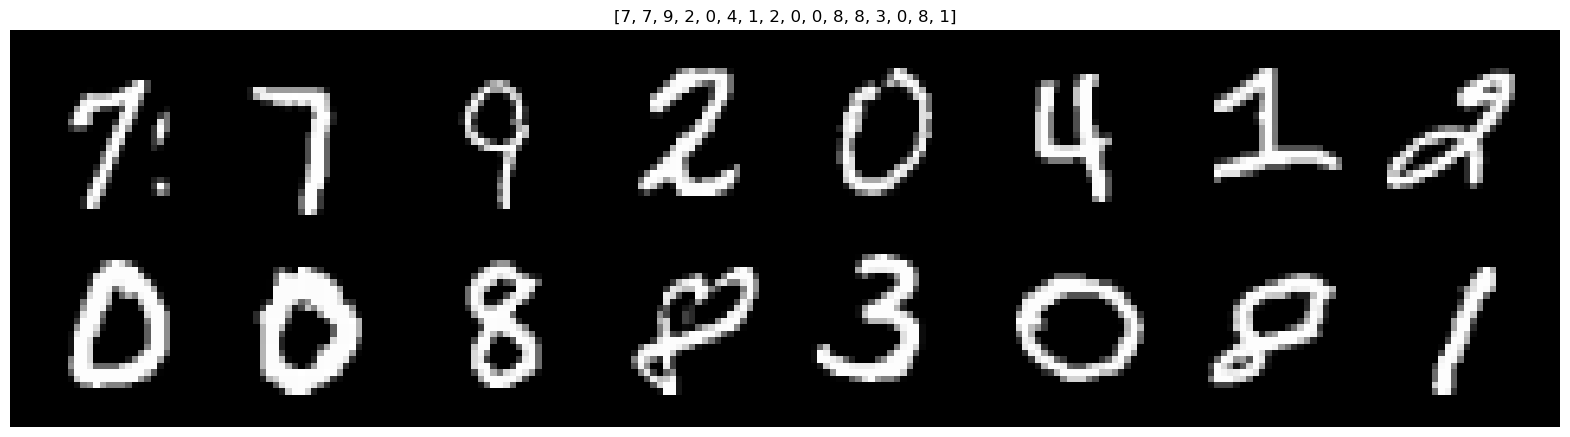

In [12]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


fig = plt.figure(figsize=(20, 10))
plt.axis("off")
inputs_new = inputs.unsqueeze(1)
out = torchvision.utils.make_grid(inputs_new)
imshow(out, title=[_class.item() for _class in classes])

In [13]:
if torch.cuda.is_available():
    model_ft = model_ft.to(device)

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f"Epoch {epoch}/{num_epochs - 1}")
            print("-" * 10)

            # Each epoch has a training and validation phase
            for phase in ["train", "val"]:
                if phase == "train":
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    inputs = inputs.unsqueeze(1)
                    inputs = torch.cat((inputs, inputs, inputs), 1)
                    inputs = F.resize(inputs, 224)

                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == "train":
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
    
                print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
                return model
                # deep copy the model
                if phase == "val" and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(
            f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
        )
        print(f"Best val Acc: {best_acc:4f}")

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    running_corrects = 0.0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs = inputs.unsqueeze(1)
            inputs = torch.cat((inputs, inputs, inputs), 1)
            inputs = F.resize(inputs, 224)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data).float()

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {preds[j]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        
        model.train(mode=was_training)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = SGD(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=3
)

Epoch 0/2
----------
train Loss: 0.1527 Acc: 0.9540


In [16]:
def confusion_matrix(preds, labels, conf_matrix):
    for p, t in zip(preds, labels):
        conf_matrix[p, t]  += 1
    return conf_matrix


def evaluate_model(model):
    
    model.eval()
    images_so_far = 0
    running_corrects, running_loss = 0.0, 0.0
    conf_matrix = torch.zeros(num_classes, num_classes)
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs = inputs.unsqueeze(1)
            inputs = torch.cat((inputs, inputs, inputs), 1)
            inputs = F.resize(inputs, 224)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            conf_matrix = confusion_matrix(preds, labels, conf_matrix)
            running_corrects += torch.sum(preds == labels.data).float()
            running_loss += loss.item() * inputs.size(0)

    test_loss = running_loss / dataset_sizes['test']
    test_acc = running_corrects.double() / dataset_sizes['test']
    print(f'test loss: {test_loss:.4f}, acc: {test_acc:.4f}')

    return conf_matrix

In [17]:
conf_matrix = evaluate_model(model_ft)

test loss: 0.0437, acc: 0.9850


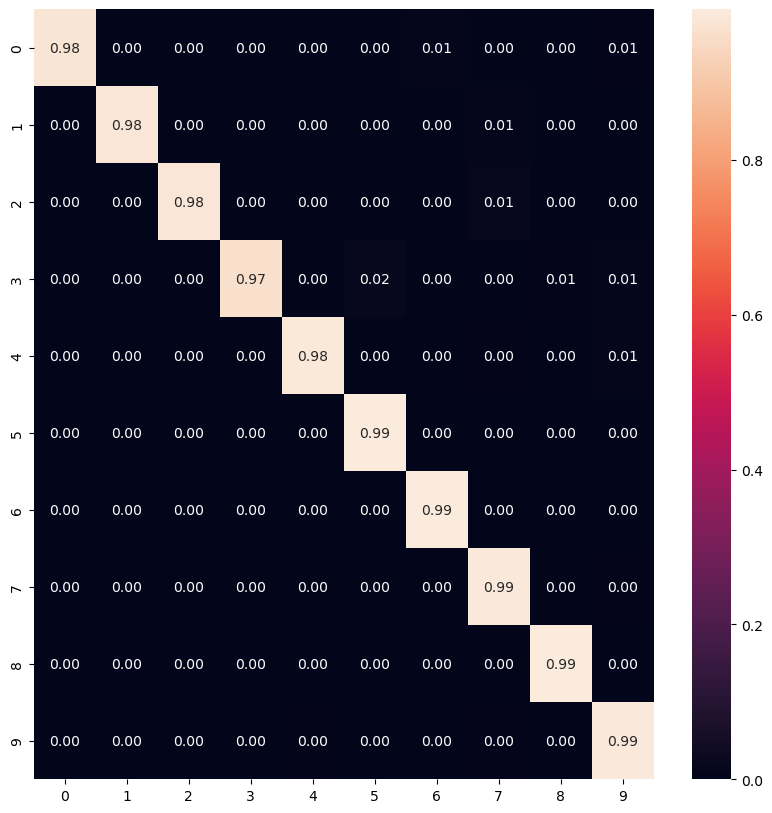

In [18]:
conf_matrix_norm = (conf_matrix / conf_matrix.sum(dim=1)).numpy()
fig, ax = plt.subplots(figsize=(10,10))
plt.ylabel('Actual')
plt.xlabel('Predicted')
sns.heatmap(
    conf_matrix_norm, 
    annot=True,
    fmt='.2f', 
    xticklabels=[str(i) for i in range(10)], 
    yticklabels=[str(i) for i in range(10)]
)
plt.show();

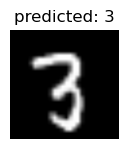

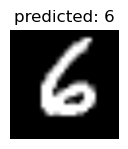

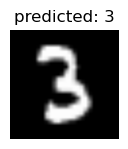

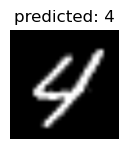

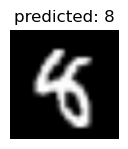

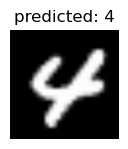

In [19]:
visualize_model(model_ft)


### PyTorch way

In [20]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784, 128, bias=True)
        self.activation = nn.ReLU()
        self.l2 = nn.Linear(128, 10, bias=True)
        self.log_sotmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.l1(x)
        x = self.activation(x)
        x = self.l2(x)
        x = self.log_sotmax(x)
        return x

In [21]:
def plot_loss_accuracy(loss_history, acc_history):
    epochs = range(1, len(loss_history) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_history, "b", label="Training loss")
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc_history, "r", label="Training accuracy")
    plt.title("Training Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [22]:
pytorch_mlp = MLP()
optimizer = SGD(pytorch_mlp.parameters(), lr=1e-3)
loss_fn = nn.NLLLoss()
n_epochs = 25
batch_size = 32
num_batches = ((X_train.shape[0] - 1) // batch_size) + 1

loss_history = []
acc_history = []

for epoch in tqdm(range(n_epochs)):
    batch_acc = 0
    batch_loss = 0
    for idx in range(0, X_train.shape[0], batch_size):

        end_idx = min(idx + batch_size, X_train.shape[0])
        actual_batch_size = end_idx - idx

        X_train_batched = X_train[idx:end_idx].reshape(actual_batch_size, -1)
        targets = y_train[idx : idx + batch_size].flatten()

        logits = pytorch_mlp(X_train_batched)
        loss = loss_fn(logits, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, y_hat = torch.max(logits, dim=1)
        accuracy = (y_hat == targets).float().mean()

        batch_acc += accuracy.item()
        batch_loss += loss.item()

    epoch_loss = batch_loss / num_batches
    epoch_acc = batch_acc / num_batches
    print(f"Epoch: {epoch}, Loss: {epoch_loss:.4f}, accuracy: {epoch_acc * 100:.2f}%")

    loss_history.append(epoch_loss)
    acc_history.append(epoch_acc)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0, Loss: 2.1209, accuracy: 49.49%
Epoch: 1, Loss: 1.5714, accuracy: 74.93%
Epoch: 2, Loss: 1.0586, accuracy: 80.71%
Epoch: 3, Loss: 0.7855, accuracy: 83.55%
Epoch: 4, Loss: 0.6478, accuracy: 85.20%
Epoch: 5, Loss: 0.5678, accuracy: 86.35%
Epoch: 6, Loss: 0.5156, accuracy: 87.17%
Epoch: 7, Loss: 0.4789, accuracy: 87.76%
Epoch: 8, Loss: 0.4515, accuracy: 88.24%
Epoch: 9, Loss: 0.4304, accuracy: 88.61%
Epoch: 10, Loss: 0.4136, accuracy: 88.92%
Epoch: 11, Loss: 0.3997, accuracy: 89.16%
Epoch: 12, Loss: 0.3882, accuracy: 89.39%
Epoch: 13, Loss: 0.3783, accuracy: 89.58%
Epoch: 14, Loss: 0.3697, accuracy: 89.75%
Epoch: 15, Loss: 0.3621, accuracy: 89.91%
Epoch: 16, Loss: 0.3554, accuracy: 90.03%
Epoch: 17, Loss: 0.3493, accuracy: 90.17%
Epoch: 18, Loss: 0.3438, accuracy: 90.31%
Epoch: 19, Loss: 0.3387, accuracy: 90.44%
Epoch: 20, Loss: 0.3340, accuracy: 90.55%
Epoch: 21, Loss: 0.3296, accuracy: 90.69%
Epoch: 22, Loss: 0.3255, accuracy: 90.80%
Epoch: 23, Loss: 0.3217, accuracy: 90.93%
Ep

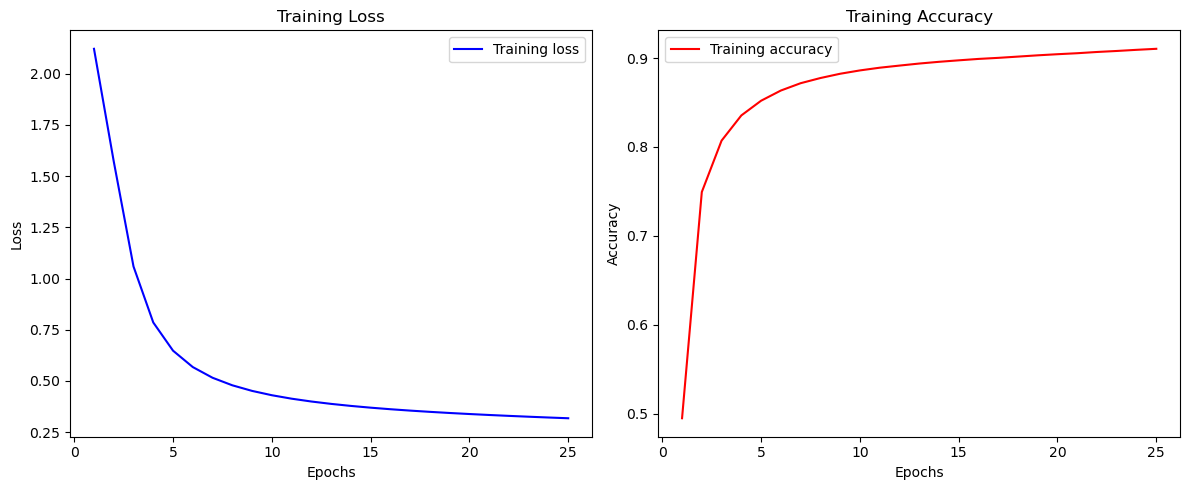

In [23]:
plot_loss_accuracy(loss_history, acc_history)

In [24]:
num_test_batches = ((X_test.shape[0] - 1) // batch_size) + 1

pytorch_mlp.eval()
with torch.no_grad():
    test_batch_loss = 0.0
    test_batch_acc = 0.0
    conf_matrix = torch.zeros(num_classes, num_classes)
    for idx in range(0, X_test.shape[0], batch_size):
        end_idx = min(idx + batch_size, X_test.shape[0])
        actual_batch_size = end_idx - idx

        X_test_batched = X_test[idx:end_idx].reshape(actual_batch_size, -1)
        targets = y_test[idx:end_idx].flatten()

        logits = pytorch_mlp(X_test_batched)
        loss = loss_fn(logits, targets)

        _, y_hat = torch.max(logits, dim=1)
        conf_matrix = confusion_matrix(y_hat, targets, conf_matrix)
        accuracy = (y_hat == targets).float().mean()
    
        test_batch_acc += accuracy.item()
        test_batch_loss += loss.item()

    test_loss = test_batch_loss / num_test_batches
    test_acc = test_batch_acc / num_test_batches

print(f"Test acc: {test_acc * 100:.2f}%, loss: {test_loss:.4f}")

Test acc: 91.36%, loss: 0.3021


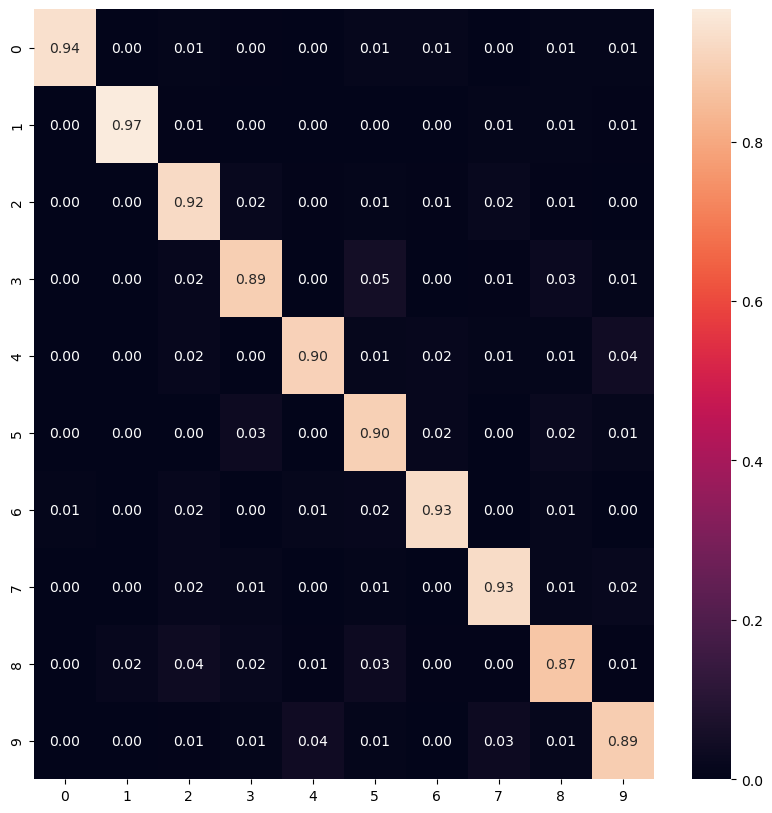

In [25]:
conf_matrix_norm = (conf_matrix / conf_matrix.sum(dim=1)).numpy()
fig, ax = plt.subplots(figsize=(10,10))
plt.ylabel('Actual')
plt.xlabel('Predicted')
sns.heatmap(
    conf_matrix_norm, 
    annot=True,
    fmt='.2f', 
    xticklabels=[str(i) for i in range(10)], 
    yticklabels=[str(i) for i in range(10)]
);
plt.show();

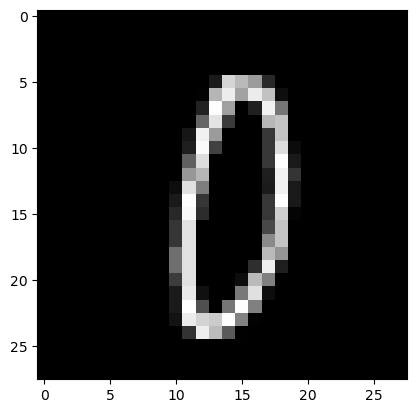

In [26]:
plt.imshow(test_images_dataset[443], cmap="gray");

In [27]:
predicted_value = torch.argmax(
    pytorch_mlp(
        torch.tensor(test_images_dataset[443], dtype=torch.float32).reshape(1, -1)
    ),
    dim=1,
)
print(f"Predicted value: {predicted_value.item()}")

Predicted value: 0


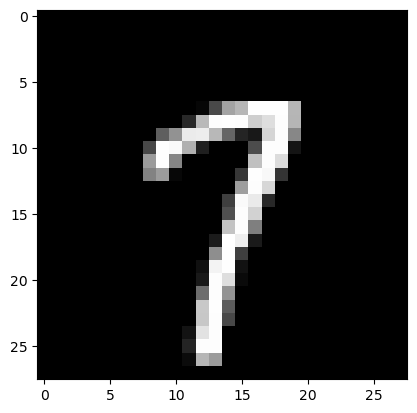

In [28]:
plt.imshow(test_images_dataset[666], cmap="gray");

In [29]:
predicted_value = torch.argmax(
    pytorch_mlp(
        torch.tensor(test_images_dataset[663], dtype=torch.float32).reshape(1, -1)
    ),
    dim=1,
)
print(f"Predicted value: {predicted_value.item()}")

Predicted value: 1


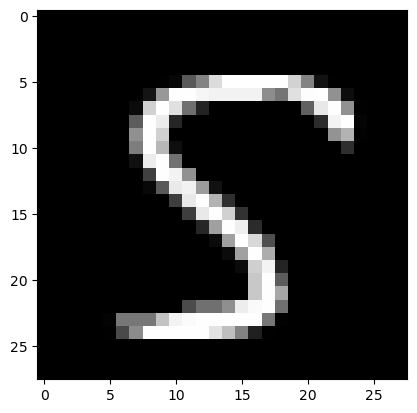

In [30]:
plt.imshow(test_images_dataset[333], cmap="gray");

In [31]:
predicted_value = torch.argmax(
    pytorch_mlp(
        torch.tensor(test_images_dataset[333], dtype=torch.float32).reshape(1, -1)
    ),
    dim=1,
)
print(f"Predicted value: {predicted_value.item()}")

Predicted value: 5


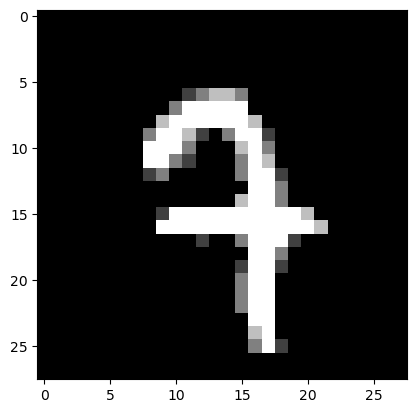

In [32]:
plt.imshow(test_images_dataset[3333], cmap="gray");

In [33]:
predicted_value = torch.argmax(
    pytorch_mlp(
        torch.tensor(test_images_dataset[3333], dtype=torch.float32).reshape(1, -1)
    ),
    dim=1,
)
print(f"Predicted value: {predicted_value.item()}")

Predicted value: 9


### NumPy way

In [34]:
def glorot_init(f_in, f_out):
    limit = np.sqrt(6 / float(f_in + f_out))
    return np.random.uniform(low=-limit, high=limit, size=(f_in, f_out)).astype(
        np.float32
    )


def bias_init(constant, shape):
    return np.full(fill_value=constant, shape=(shape, 1)).astype(np.float32)


def relu(x):
    return np.maximum(0, x)


def d_relu(x):
    return (x >= 0).astype(np.float32)


def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1, keepdims=True)


def logsoftmax(x):
    return np.log(softmax(x))


def d_logsoftmax(y_true, y_hat):
    y_hat_softmax = softmax(y_hat)
    grad = np.zeros_like(y_hat_softmax)
    N = y_hat.shape[0]
    grad[np.arange(N), y_true] = 1
    grad = y_hat_softmax - grad
    return grad


def negative_log_likelihood(y_true, y_hat):
    epsilon = 1e-8
    y_hat = np.exp(y_hat)
    y_hat = np.clip(y_hat, epsilon, 1.0 - epsilon)
    N = y_hat.shape[0]
    nll_loss = -np.log(y_hat[np.arange(N), y_true] + epsilon)
    return nll_loss

In [35]:
class LinearLayer:
    def __init__(self, input_dim, output_dim, activation_func=None, bias=True):
        self.weights = glorot_init(input_dim, output_dim)
        self.activation_func = activation_func
        self.bias = None
        self.input = None
        self.dw = None
        self.db = None
        if bias:
            self.bias = bias_init(1e-3, shape=output_dim)

    def forward(self, x):
        self.input = x
        z = x @ self.weights + self.bias.squeeze()
        if self.activation_func is not None:
            return self.activation_func.forward(z)

        return z

    def backward(self, gradient):
        if self.activation_func is not None:
            gradient = self.activation_func.backward(gradient)

        self.db = np.sum(gradient, axis=0, keepdims=True).T
        self.dw = np.dot(self.input.T, gradient)

        return np.dot(gradient, self.weights.T)


class ReLU:
    def __init__(self):
        self.input = None

    def forward(self, x):
        self.input = x
        return relu(x)

    def backward(self, gradient):
        return d_relu(self.input) * gradient


class NLLLoss:
    def __init__(self):
        self.logits = None
        self.targets = None

    def __call__(self, targets, logits):
        self.logits = logits
        self.targets = targets
        return negative_log_likelihood(self.targets, self.logits)

    def backward(self):
        return d_logsoftmax(self.targets, self.logits)


class LogSoftmax:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, x):
        self.input = x
        self.output = logsoftmax(x)
        return self.output

    def backward(self, gradient):
        y_softmax = softmax(self.output)
        return gradient - np.sum(gradient, axis=1, keepdims=True) * y_softmax


class ScratchMLP:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        return self._forward_pass(x)

    def _forward_pass(self, x):
        for layer in self.layers:
            x = layer.forward(x)

        return x

    def _backward_pass(self, loss_gradient):
        for layer in reversed(self.layers):
            loss_gradient = layer.backward(loss_gradient)

    def backward(self, loss_gradient):
        self._backward_pass(loss_gradient)

In [36]:
X_train = train_images_dataset.reshape(-1, 28 * 28) / 255.0
y_train = train_labels_dataset.reshape(-1, 1)
X_test = test_images_dataset.reshape(-1, 28 * 28) / 255.0
y_test = test_labels_dataset.reshape(-1, 1)

p = np.random.permutation(len(X_train))
X_train, y_train = X_train[p], y_train[p]

n_features = 28 * 28
n_classes = 10

model = ScratchMLP(
    [
        LinearLayer(n_features, 128, activation_func=ReLU()),
        LinearLayer(128, n_classes, activation_func=LogSoftmax()),
    ]
)

loss_fn = NLLLoss()

batch_size = 64
epochs = 15
lr = 1e-3
num_batches = ((X_train.shape[0] - 1) // batch_size) + 1

loss_history, acc_history = [], []

for epoch in tqdm(range(epochs)):
    batch_acc = 0
    batch_loss = 0
    for idx in range(0, X_train.shape[0], batch_size):

        end_idx = min(idx + batch_size, X_train.shape[0])
        actual_batch_size = end_idx - idx

        for layer in model.layers:
            layer.db = 0.0
            layer.dw = 0.0

        X_train_batched = X_train[idx:end_idx].reshape(actual_batch_size, -1)
        y_train_batched = y_train[idx:end_idx].flatten()
        logits = model(X_train_batched)
        loss = loss_fn(y_train_batched, logits)
        loss_gradient = loss_fn.backward()
        model.backward(loss_gradient)

        # gradient descent
        for layer in model.layers:
            layer.weights -= lr * layer.dw
            layer.bias -= lr * layer.db

        accuracy = np.mean((np.argmax(logits, axis=1) == y_train_batched))
        batch_acc += accuracy
        batch_loss += np.mean(loss)  # mean of batch loss

    epoch_loss = batch_loss / num_batches
    epoch_acc = batch_acc / num_batches
    print(f"Epoch: {epoch}, Loss: {epoch_loss:.4f}, accuracy: {epoch_acc * 100:.2f}%")

    loss_history.append(epoch_loss)
    acc_history.append(epoch_acc)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.4269, accuracy: 88.35%
Epoch: 1, Loss: 0.2406, accuracy: 93.22%
Epoch: 2, Loss: 0.1894, accuracy: 94.68%
Epoch: 3, Loss: 0.1576, accuracy: 95.56%
Epoch: 4, Loss: 0.1357, accuracy: 96.18%
Epoch: 5, Loss: 0.1194, accuracy: 96.69%
Epoch: 6, Loss: 0.1067, accuracy: 97.03%
Epoch: 7, Loss: 0.0964, accuracy: 97.29%
Epoch: 8, Loss: 0.0878, accuracy: 97.52%
Epoch: 9, Loss: 0.0805, accuracy: 97.73%
Epoch: 10, Loss: 0.0742, accuracy: 97.91%
Epoch: 11, Loss: 0.0687, accuracy: 98.09%
Epoch: 12, Loss: 0.0639, accuracy: 98.24%
Epoch: 13, Loss: 0.0596, accuracy: 98.39%
Epoch: 14, Loss: 0.0558, accuracy: 98.50%


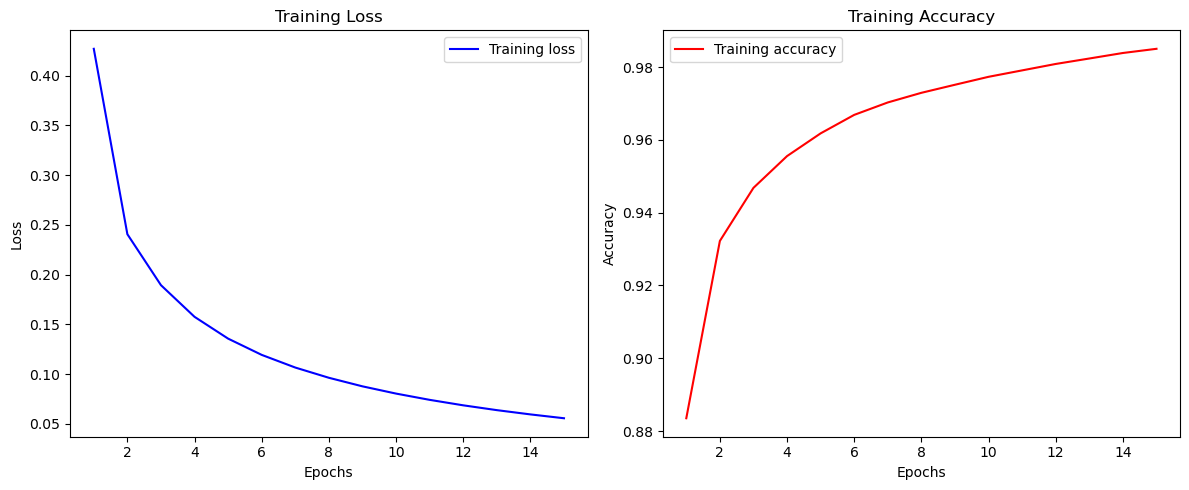

In [37]:
plot_loss_accuracy(loss_history, acc_history);

In [38]:
num_test_batches = ((X_test.shape[0] - 1) // batch_size) + 1

test_batch_loss = 0.0
test_batch_acc = 0.0
conf_matrix = np.zeros((num_classes, num_classes))
for idx in range(0, X_test.shape[0], batch_size):
    end_idx = min(idx + batch_size, X_test.shape[0])
    actual_batch_size = end_idx - idx
    X_test_batched = X_test[idx:end_idx].reshape(actual_batch_size, -1)
    targets = y_test[idx:end_idx].flatten()

    logits = model(X_test_batched)
    loss = loss_fn(targets, logits)

    preds = np.argmax(logits, axis=1)
    conf_matrix = confusion_matrix(preds, targets, conf_matrix)
    accuracy = (preds == targets).mean()

    test_batch_acc += accuracy
    test_batch_loss += np.mean(loss)

test_loss = test_batch_loss / num_test_batches
test_acc = test_batch_acc / num_test_batches

print(f"Test acc: {test_acc * 100:.2f}%, loss: {test_loss:.4f}")

Test acc: 97.44%, loss: 0.0820


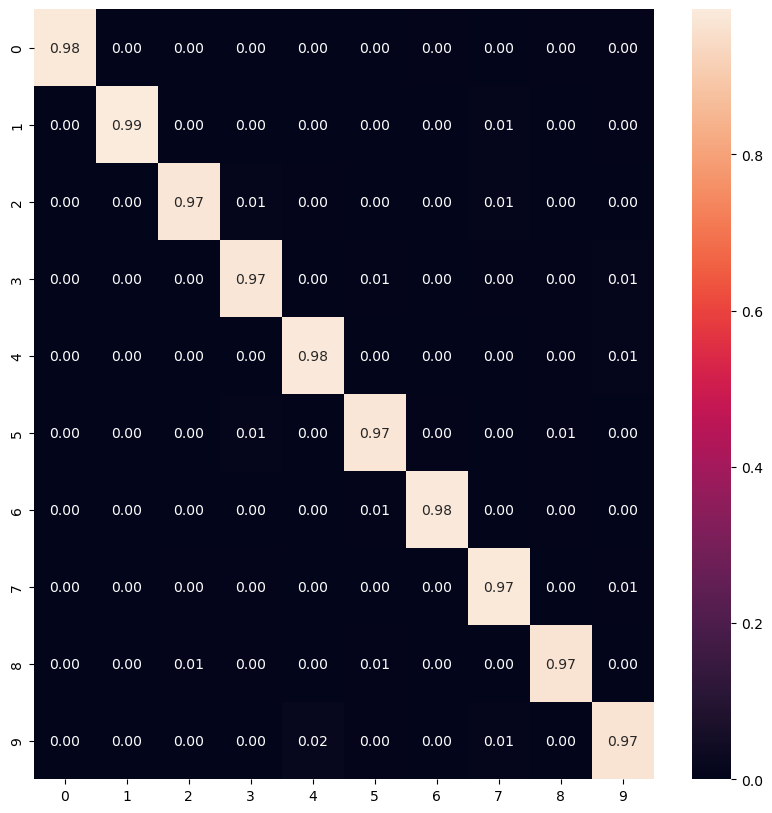

In [39]:
conf_matrix_norm = (conf_matrix / conf_matrix.sum(axis=1))
fig, ax = plt.subplots(figsize=(10,10))
plt.ylabel('Actual')
plt.xlabel('Predicted')
sns.heatmap(
    conf_matrix_norm, 
    annot=True,
    fmt='.2f', 
    xticklabels=[str(i) for i in range(10)], 
    yticklabels=[str(i) for i in range(10)]
)
plt.show();

Predicted value: 9


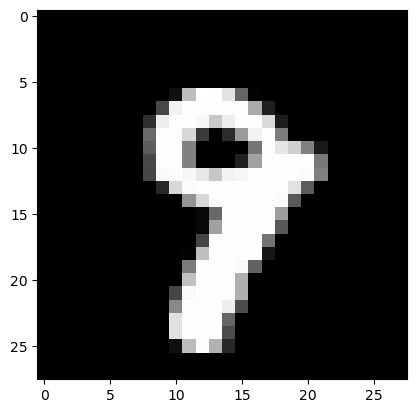

In [40]:
rnd_idx = np.random.randint(X_test.shape[0])
predicted_value = np.argmax(
    model(np.array(test_images_dataset[rnd_idx], dtype=np.float32).reshape(1, -1)),
    axis=1,
)
plt.imshow(test_images_dataset[rnd_idx], cmap="gray")
print(f"Predicted value: {predicted_value.item()}")

Predicted value: 5


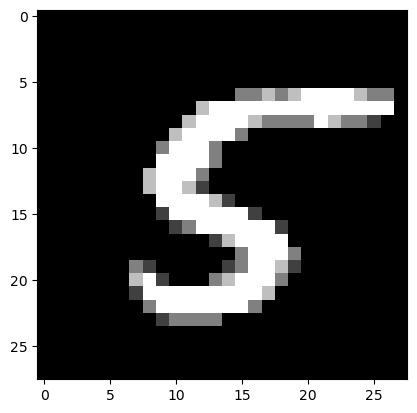

In [41]:
rnd_idx = np.random.randint(X_test.shape[0])
predicted_value = np.argmax(
    model(np.array(test_images_dataset[rnd_idx], dtype=np.float32).reshape(1, -1)),
    axis=1,
)
plt.imshow(test_images_dataset[rnd_idx], cmap="gray")
print(f"Predicted value: {predicted_value.item()}")

Predicted value: 2


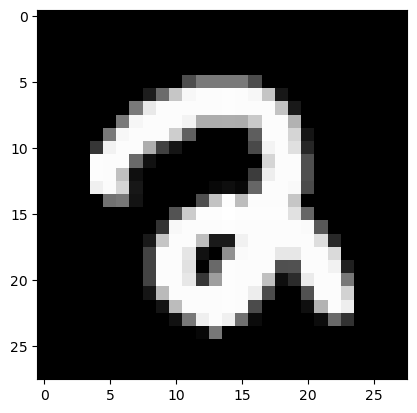

In [42]:
rnd_idx = np.random.randint(X_test.shape[0])
predicted_value = np.argmax(
    model(np.array(test_images_dataset[rnd_idx], dtype=np.float32).reshape(1, -1)),
    axis=1,
)
plt.imshow(test_images_dataset[rnd_idx], cmap="gray")
print(f"Predicted value: {predicted_value.item()}")

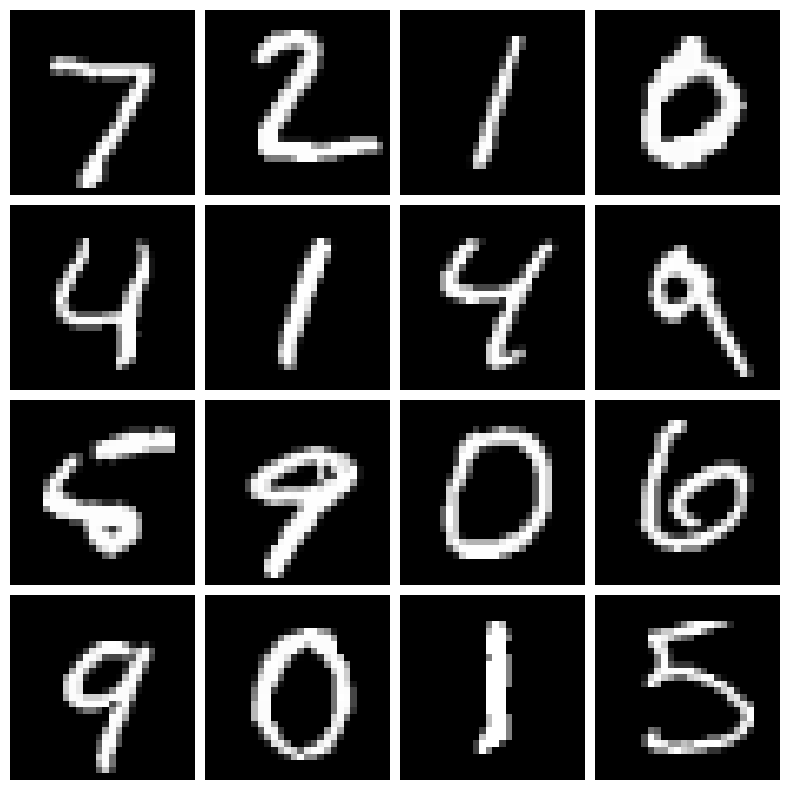

In [43]:
show_grid(16, test_images_dataset)

In [44]:
for image in test_images_dataset[:16, :, :]:
    logits = model(np.array(image, dtype=np.float32).reshape(1, -1))
    prediction = np.argmax(logits, axis=1)
    print(f"Model prediction: {prediction[0]}")

Model prediction: 7
Model prediction: 2
Model prediction: 1
Model prediction: 0
Model prediction: 4
Model prediction: 1
Model prediction: 4
Model prediction: 9
Model prediction: 6
Model prediction: 9
Model prediction: 0
Model prediction: 6
Model prediction: 9
Model prediction: 0
Model prediction: 1
Model prediction: 5


### Real scratch

In [45]:
nn = {}

nn["l1"] = glorot_init(784, 128)
nn["b1"] = bias_init(0.001, shape=128).flatten()
nn["l2"] = glorot_init(128, 10)
nn["b2"] = bias_init(0.001, shape=10).flatten()

X_train = train_images_dataset.reshape(-1, 28 * 28) / 255.0
y_train = train_labels_dataset.reshape(-1, 1)
X_test = test_images_dataset.reshape(-1, 28 * 28) / 255.0
y_test = test_labels_dataset.reshape(-1, 1)

p = np.random.permutation(len(X_train))
X_train, y_train = X_train[p], y_train[p]

# 1, 784 x 784, 128 =  1, 128
# 1, 128 * 128, 10 = 1, 10
lr = 1e-4
n_epochs = 100
batch_size = 128
num_batches = ((X_train.shape[0] - 1) // batch_size) + 1

losses, accuracies = [], []
for epoch in tqdm(range(n_epochs)):

    nll_loss_sum, batch_acc = 0.0, 0.0
    for i in range(0, len(X_train), batch_size):

        dL_dLSM, dL_dL2, dL_dB2, dL_dB1, dL_dL1 = (
            np.zeros((1, 10)),
            np.zeros((128, 10)),
            np.zeros((10)),
            np.zeros((128)),
            np.zeros((784, 128)),
        )

        end_idx = min(i + batch_size, X_train.shape[0])
        actual_batch_size = end_idx - i

        X_batch = X_train[i:end_idx].reshape(actual_batch_size, -1)
        y_batch = y_train[i:end_idx].flatten()

        # Forward pass
        l1_activations = X_batch @ nn["l1"] + nn["b1"]
        x_relu = relu(l1_activations)
        l2_activations = x_relu @ nn["l2"] + nn["b2"]
        logits = logsoftmax(l2_activations)

        # Compute the loss
        nll_loss = negative_log_likelihood(y_batch, logits)
        y_preds = np.argmax(logits, axis=1)

        # backward pass
        dL_dLSM = d_logsoftmax(y_batch, logits)

        # gradient for l2 and b2
        dL_dL2 = x_relu.T @ dL_dLSM
        dL_dB2 = np.sum(dL_dLSM, axis=0)

        # gradient for x_relu
        dL_dx_relu = dL_dLSM @ nn["l2"].T
        dL_dx = d_relu(l1_activations) * dL_dx_relu

        # gradient for l1 and b1
        dL_dL1 = X_batch.T @ dL_dx
        dL_dB1 = np.sum(dL_dx, axis=0)

        # update weights and biases
        nn["l1"] -= lr * dL_dL1 / batch_size
        nn["b1"] -= lr * dL_dB1 / batch_size
        nn["l2"] -= lr * dL_dL2 / batch_size
        nn["b2"] -= lr * dL_dB2 / batch_size

        nll_loss_sum += np.mean(nll_loss)
        batch_acc += (y_preds == y_batch).mean()

    train_loss = nll_loss_sum / num_batches
    train_acc = batch_acc / num_batches
    if epoch % 10 == 0 and epoch != 0:
        print(
            f"Epoch: {epoch}, train loss: {train_loss:.4f}, train acc: {train_acc * 100:.2f}%"
        )

    losses.append(train_loss)
    accuracies.append(train_acc)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10, train loss: 2.0149, train acc: 42.49%
Epoch: 20, train loss: 1.7095, train acc: 64.00%
Epoch: 30, train loss: 1.4476, train acc: 71.58%
Epoch: 40, train loss: 1.2389, train acc: 75.76%
Epoch: 50, train loss: 1.0800, train acc: 78.50%
Epoch: 60, train loss: 0.9602, train acc: 80.26%
Epoch: 70, train loss: 0.8691, train acc: 81.63%
Epoch: 80, train loss: 0.7985, train acc: 82.69%
Epoch: 90, train loss: 0.7427, train acc: 83.50%


In [46]:
num_test_batches = ((X_test.shape[0] - 1) // batch_size) + 1

test_batch_loss = 0.0
test_batch_acc = 0.0
conf_matrix = np.zeros((num_classes, num_classes))
for idx in range(0, X_test.shape[0], batch_size):
    end_idx = min(idx + batch_size, X_test.shape[0])
    actual_batch_size = end_idx - idx
    X_test_batched = X_test[idx:end_idx].reshape(actual_batch_size, -1)
    targets = y_test[idx:end_idx].flatten()

    x = X_test_batched @ nn['l1'] + nn['b1']
    x = relu(x)
    x = x @ nn['l2'] + nn['b2']
    logits = logsoftmax(x)
    
    nll_loss = negative_log_likelihood(targets, logits)

    preds = np.argmax(logits, axis=1)
    conf_matrix = confusion_matrix(preds, targets, conf_matrix)
    accuracy = (preds == targets).mean()

    test_batch_acc += accuracy
    test_batch_loss += np.mean(loss)

test_loss = test_batch_loss / num_test_batches
test_acc = test_batch_acc / num_test_batches

print(f"Test acc: {test_acc * 100:.2f}%, loss: {test_loss:.4f}")

Test acc: 85.38%, loss: 0.0022


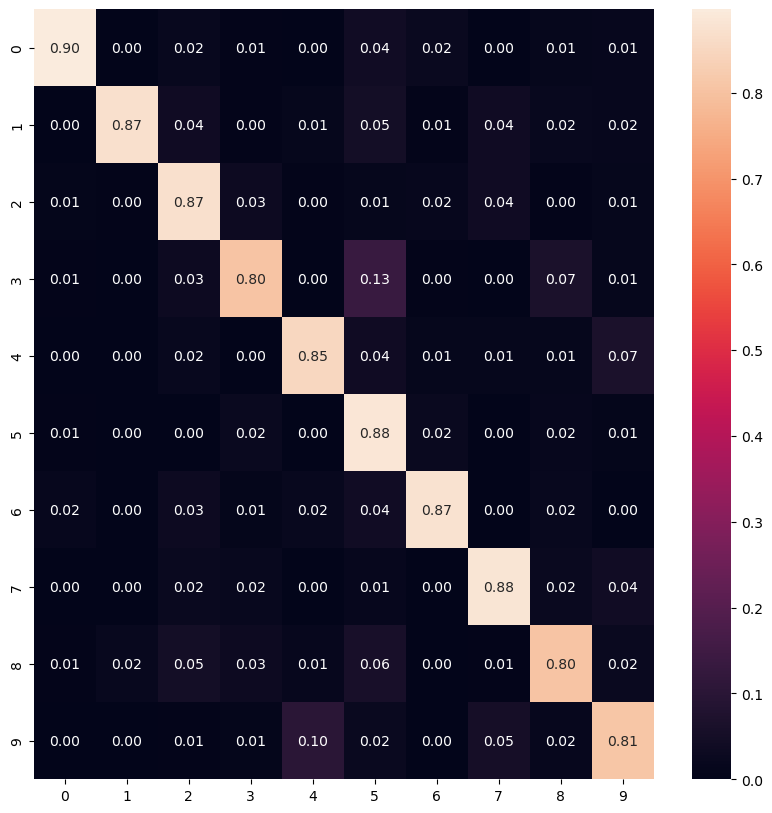

In [47]:
conf_matrix_norm = (conf_matrix / conf_matrix.sum(axis=1))
fig, ax = plt.subplots(figsize=(10,10))
plt.ylabel('Actual')
plt.xlabel('Predicted')
sns.heatmap(
    conf_matrix_norm, 
    annot=True,
    fmt='.2f', 
    xticklabels=[str(i) for i in range(10)], 
    yticklabels=[str(i) for i in range(10)]
)
plt.show();